In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/road-accident-survival-dataset/accident.csv


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from plotly.offline import init_notebook_mode
import warnings

init_notebook_mode(connected=True)
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_theme(style='whitegrid')

In [9]:
df = pd.read_csv('/kaggle/input/road-accident-survival-dataset/accident.csv')

print("Shape of the DataFrame:\n")
print(df.shape)
print("-"  * 25 + "\n")

print("First 5 rows of the DataFrame:\n")
print(df.head())
print("\n")

print("Information about the DataFrame:\n")
print(df.info())
print("-"  * 25 + "\n")

print("Description of numerical columns:\n")
print(df.describe().T)
print("-"  * 25 + "\n")

print("Description of categorical columns:\n")
print(df.describe(include='object').T)
print("-"  * 25 + "\n")

print("Count of missing values in each column:\n")
print(df.isnull().sum())
print("-"  * 25 + "\n")

class_distribution = df['Survived'].value_counts()
print("Class distribution:\n")
print(class_distribution)

Shape of the DataFrame:

(200, 6)
-------------------------

First 5 rows of the DataFrame:

   Age  Gender  Speed_of_Impact Helmet_Used Seatbelt_Used  Survived
0   56  Female             27.0          No            No         1
1   69  Female             46.0          No           Yes         1
2   46    Male             46.0         Yes           Yes         0
3   32    Male            117.0          No           Yes         0
4   60  Female             40.0         Yes           Yes         0


Information about the DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Gender           199 non-null    object 
 2   Speed_of_Impact  197 non-null    float64
 3   Helmet_Used      200 non-null    object 
 4   Seatbelt_Used    200 non-null    object 
 5   Survived         200 non-null   

In [10]:
df.rename(columns={'Gender': 'Female'}, inplace=True)

#df[df.isna().any(axis=1)]

df['Female'] = df['Female'].map({'Female': 1, 'Male': 0})
df['Helmet_Used'] = df['Helmet_Used'].map({'Yes': 1, 'No': 0})
df['Seatbelt_Used'] = df['Seatbelt_Used'].map({'Yes': 1, 'No': 0})

In [11]:
df.dropna(inplace=True)

In [12]:
df.head()

,Age,Female,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,1.0,27.0,0,0,1
1,69,1.0,46.0,0,1,1
2,46,0.0,46.0,1,1,0
3,32,0.0,117.0,0,1,0
4,60,1.0,40.0,1,1,0


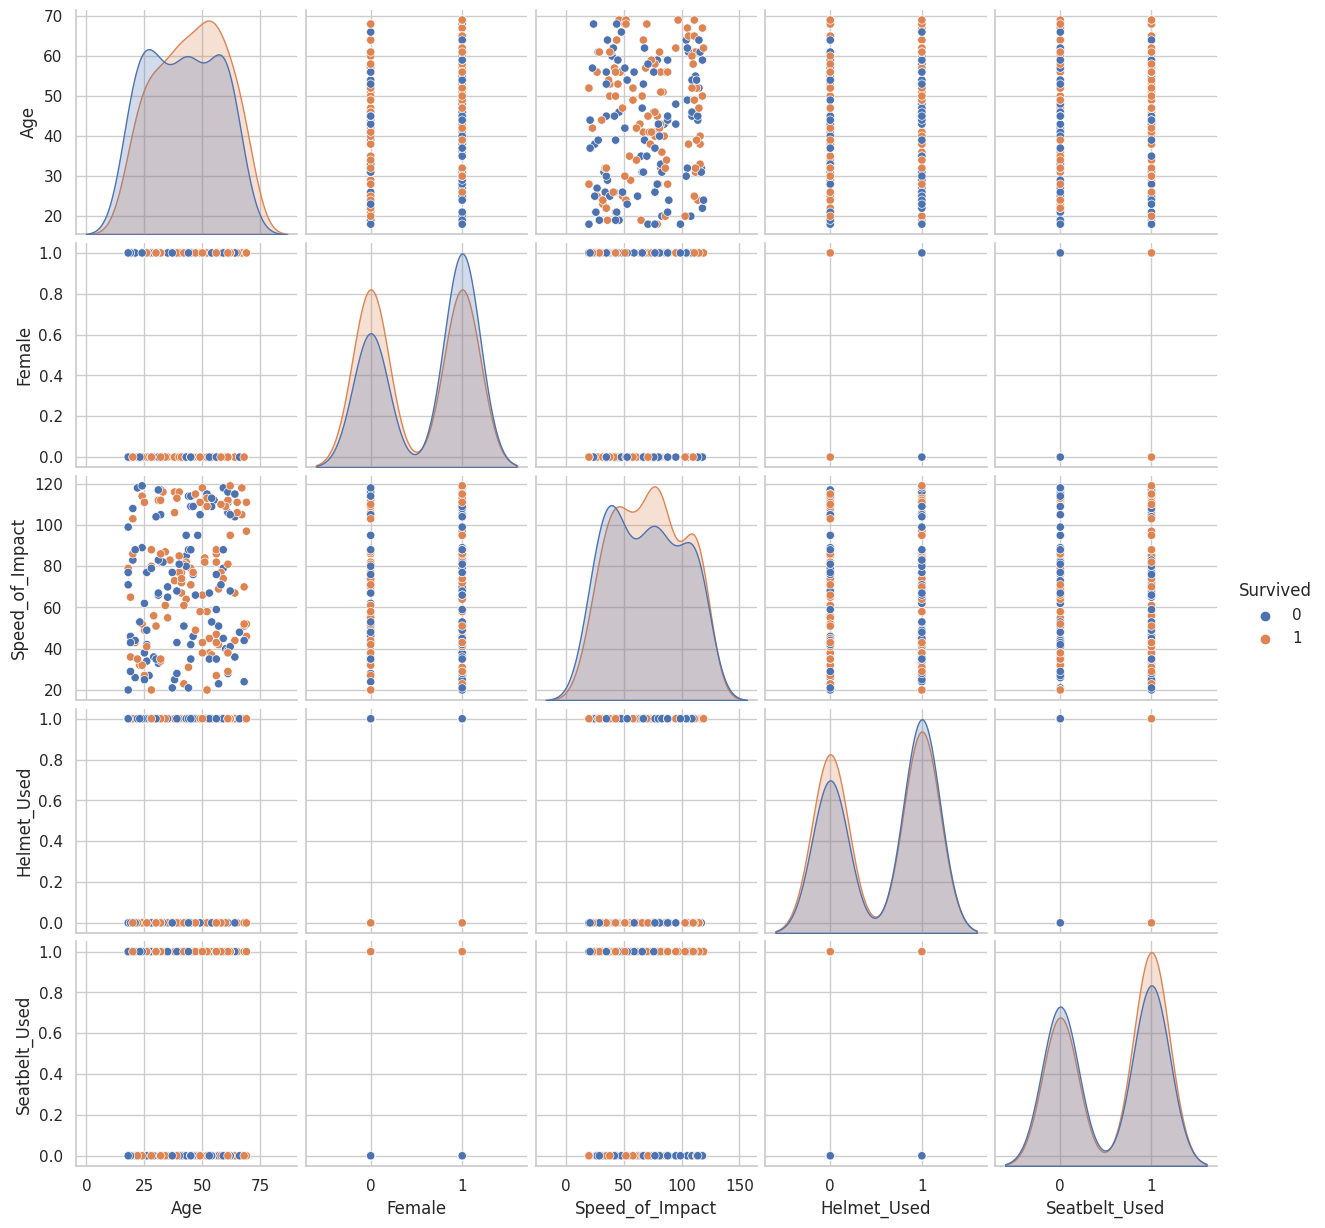

In [13]:
sns.pairplot(data=df, kind='scatter', diag_kind='kde', hue='Survived');

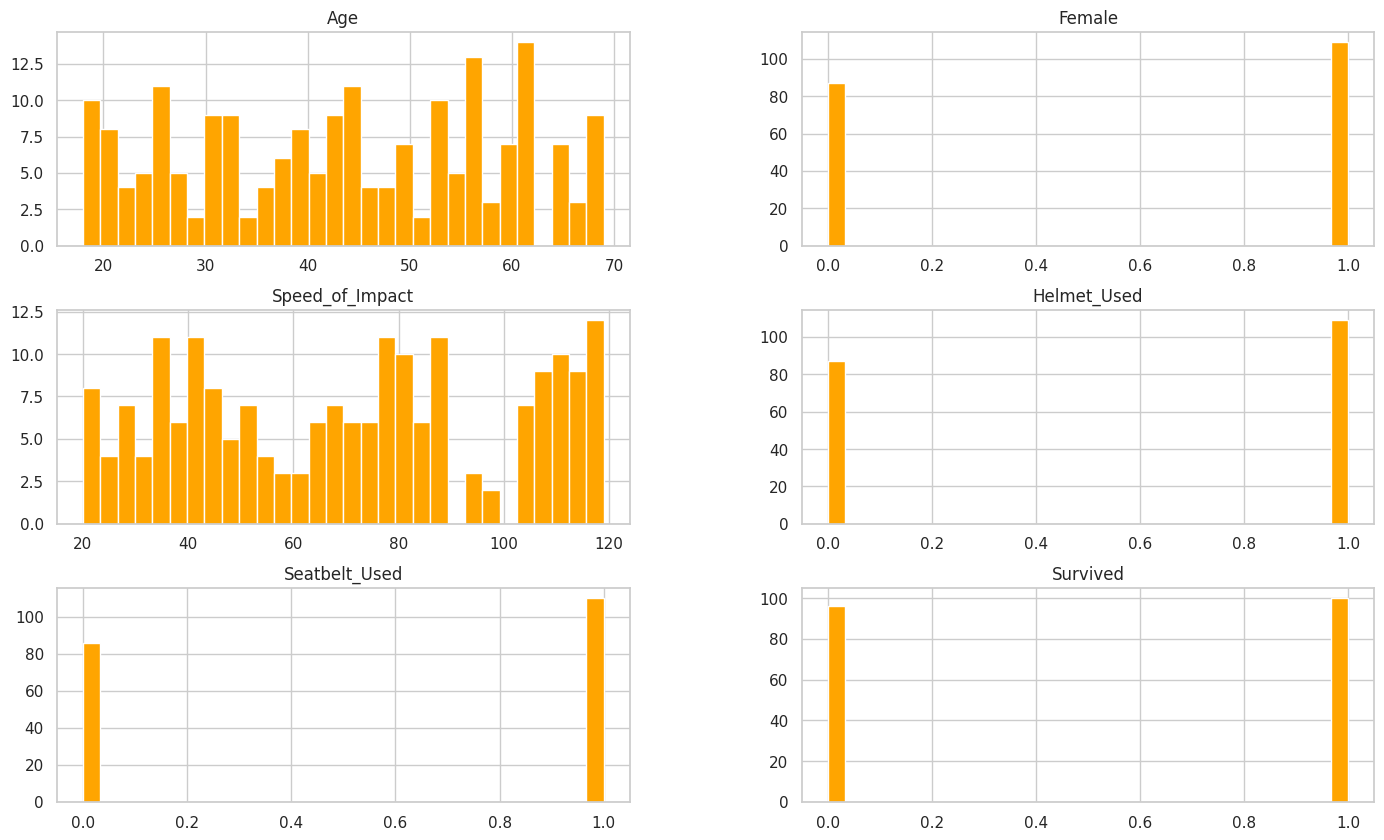

In [14]:
df.hist(bins=30, figsize=(17, 10), color='orange');

In [15]:
fig = px.scatter_3d(df, x='Age', y='Speed_of_Impact', z='Seatbelt_Used', 
                    color='Survived', animation_frame='Female', template='ggplot2',
                    title='Dependence of Survived on age, speed, seatbelt, gender')
fig.show(renderer='iframe_connected')

In [16]:
fig = px.scatter_3d(df, x='Age', y='Speed_of_Impact', z='Helmet_Used', 
                    color='Survived', animation_frame='Female', template='ggplot2',
                    title='Dependence of Survived on age, speed, helmet, gender')
fig.show(renderer='iframe_connected')

In [17]:
vl_cnt = df.groupby(['Female'])['Survived'].sum().reset_index(name='cnt')

fig = px.bar(vl_cnt, x='Female', y='cnt', template='ggplot2')
fig.show(renderer='iframe_connected')

In [18]:
fig = px.box(df, x='Survived', y='Speed_of_Impact', color='Female', template='ggplot2')
fig.show(renderer='iframe_connected')

In [19]:
fig = px.histogram(df, x='Age', y='Speed_of_Impact', color='Female', animation_frame='Survived', template='ggplot2')
fig.show(renderer='iframe_connected')

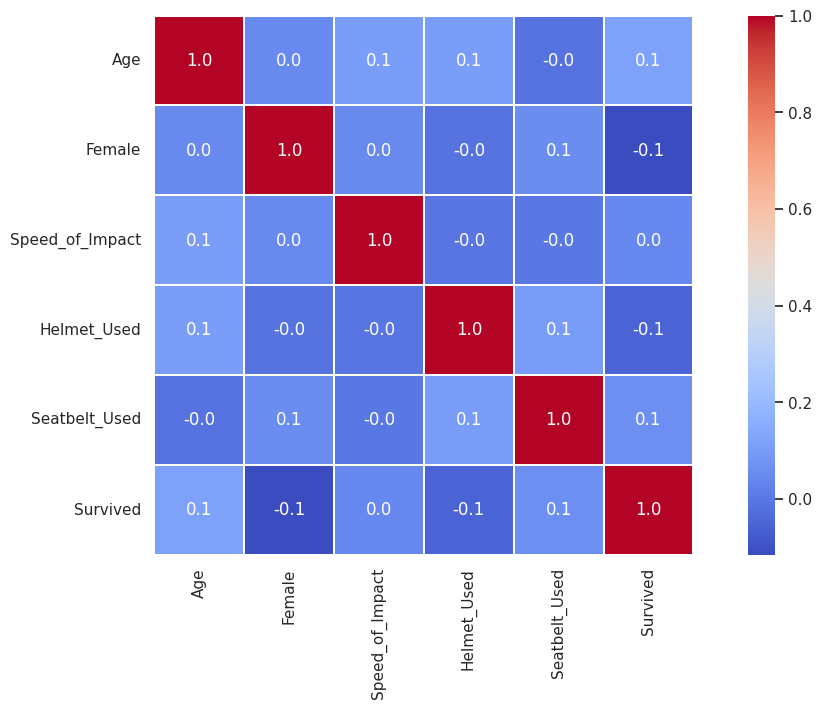

In [20]:
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(14, 7))
sns.heatmap(correlation_matrix, square=True,
            annot=True, fmt='.1f', linewidths=0.1, cmap='coolwarm');

In [53]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
        classification_report, 
        accuracy_score, 
        recall_score, 
        precision_score, 
        f1_score, 
        roc_auc_score, 
        confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE


In [54]:
X = df.drop(columns=['Survived'])
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [55]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = []

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

models_params = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'classifier__C': [0.01, 0.1, 1, 10],
            'classifier__solver': ['liblinear', 'saga']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5]
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'classifier__C': [0.1, 1, 10],
            'classifier__gamma': ['scale', 'auto']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [3, 5],
            'classifier__learning_rate': [0.01, 0.1]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(verbose=0),
        'params': {
            'classifier__iterations': [50, 100],
            'classifier__depth': [3, 5]
        }
    }
}

Best parameters for Logistic Regression: {'classifier__C': 1, 'classifier__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.44      0.55      0.49        20
           1       0.40      0.30      0.34        20

    accuracy                           0.42        40
   macro avg       0.42      0.43      0.42        40
weighted avg       0.42      0.42      0.42        40



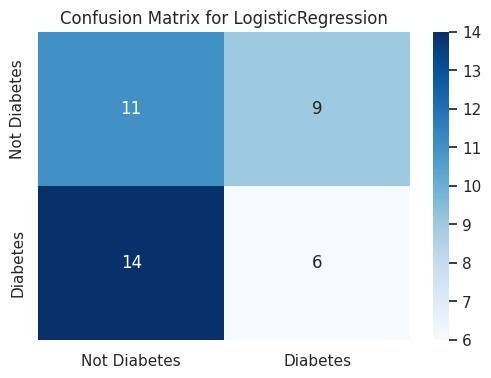

Best parameters for Decision Tree: {'classifier__max_depth': None, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        20
           1       0.62      0.50      0.56        20

    accuracy                           0.60        40
   macro avg       0.60      0.60      0.60        40
weighted avg       0.60      0.60      0.60        40



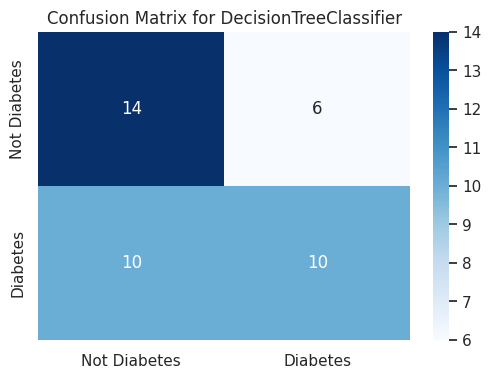

Best parameters for Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}
              precision    recall  f1-score   support

           0       0.53      0.50      0.51        20
           1       0.52      0.55      0.54        20

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.52        40



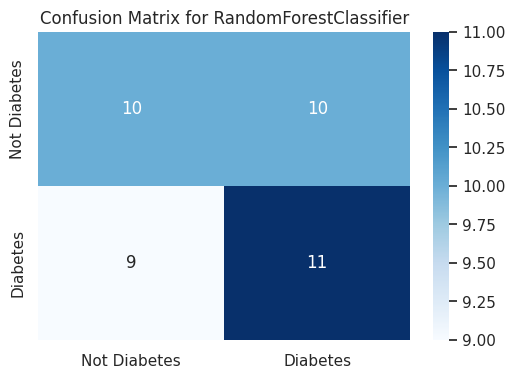

Best parameters for SVM: {'classifier__C': 0.1, 'classifier__gamma': 'scale'}
              precision    recall  f1-score   support

           0       0.52      0.60      0.56        20
           1       0.53      0.45      0.49        20

    accuracy                           0.53        40
   macro avg       0.53      0.53      0.52        40
weighted avg       0.53      0.53      0.52        40



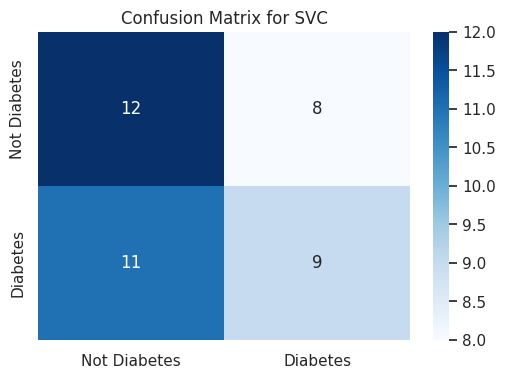

Best parameters for XGBoost: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
              precision    recall  f1-score   support

           0       0.46      0.55      0.50        20
           1       0.44      0.35      0.39        20

    accuracy                           0.45        40
   macro avg       0.45      0.45      0.44        40
weighted avg       0.45      0.45      0.44        40



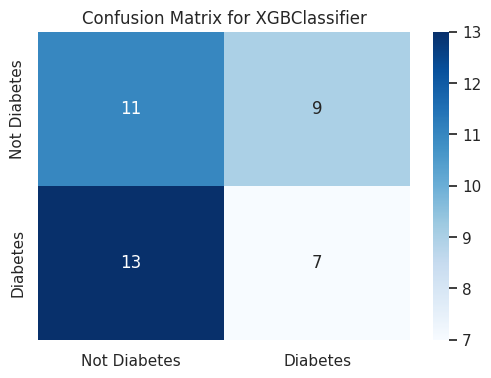

Best parameters for CatBoost: {'classifier__depth': 3, 'classifier__iterations': 50}
              precision    recall  f1-score   support

           0       0.50      0.65      0.57        20
           1       0.50      0.35      0.41        20

    accuracy                           0.50        40
   macro avg       0.50      0.50      0.49        40
weighted avg       0.50      0.50      0.49        40



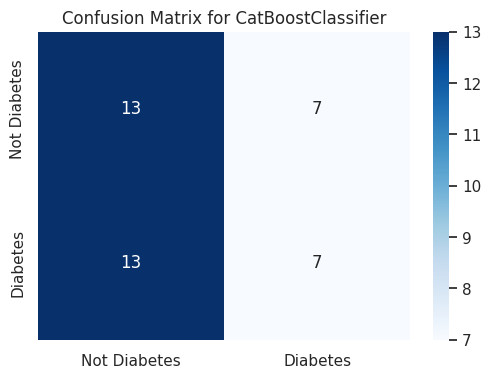

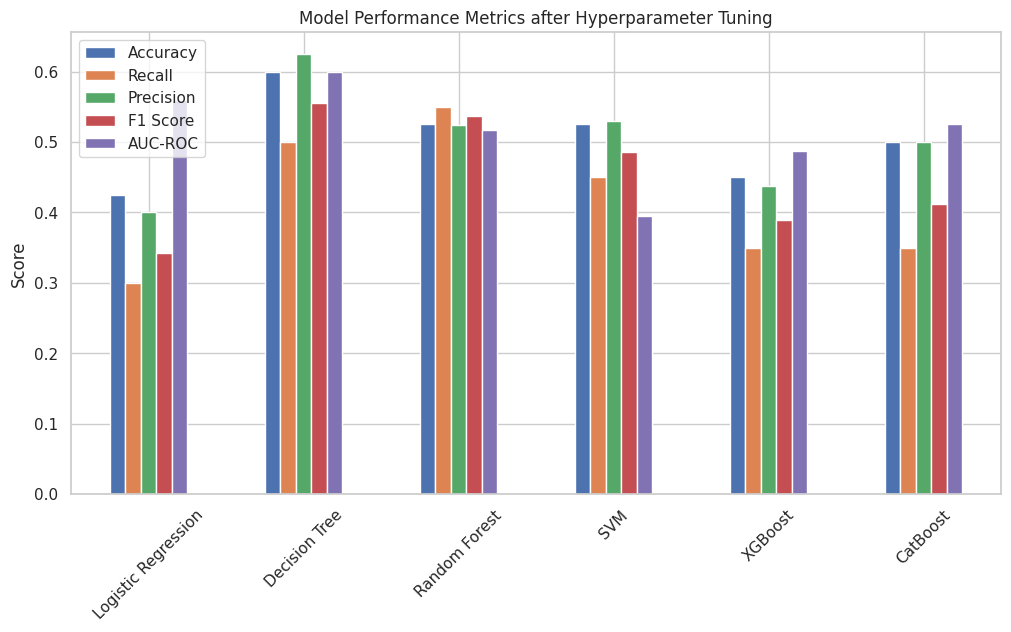

                     Accuracy  Recall  Precision  F1 Score  AUC-ROC
Logistic Regression     0.425    0.30   0.400000  0.342857   0.5600
Decision Tree           0.600    0.50   0.625000  0.555556   0.6000
Random Forest           0.525    0.55   0.523810  0.536585   0.5175
SVM                     0.525    0.45   0.529412  0.486486   0.3950
XGBoost                 0.450    0.35   0.437500  0.388889   0.4875
CatBoost                0.500    0.35   0.500000  0.411765   0.5250


In [56]:
def evaluate_model(model_pipeline):
    model_pipeline.fit(X_train, y_train)
    
    y_pred = model_pipeline.predict(X_test)
    y_proba = model_pipeline.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Diabetes', 'Diabetes'],
                yticklabels=['Not Diabetes', 'Diabetes'])
    plt.title(f'Confusion Matrix for {model_pipeline.named_steps["classifier"].__class__.__name__}')
    plt.show()
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_proba)
    }
    
    return metrics

results = {}
for name, model_info in models_params.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model_info['model'])
    ])
    
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, scoring='f1')
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    metrics = evaluate_model(grid_search.best_estimator_)
    results[name] = metrics

results_df = pd.DataFrame(results).T

results_df.plot(kind='bar', figsize=(12,6))
plt.title('Model Performance Metrics after Hyperparameter Tuning')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.show()

print(results_df)